In [4]:
import tensorflow as tf

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.layers import Input,Conv2D,PReLU,Conv2DTranspose,LeakyReLU,Flatten,Dense,Conv2DTranspose,LeakyReLU,BatchNormalization,ReLU,Reshape
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import time
from tensorflow.keras.utils import Progbar

In [4]:
'''
#for training on sagemaker
#upload dataset as zipfile

import boto3
s3 = boto3.resource('s3')
s3.Bucket('dcgan2').download_file('Abstract_gallery.zip','Abstract_gallery.zip') #replace 'dcgan2' with bucket name

os.mkdir('datasets')

import zipfile
with zipfile.ZipFile('Abstract_gallery.zip', 'r') as zip_ref:
    zip_ref.extractall('datasets')
    
path_to_image_directory='datasets/Abstract_gallery'
'''

In [6]:
path_to_image_directory='datasets/Abstract_gallery/Abstract_gallery'
num_samples=2782
#new_size=128
new_size = 32
batch_size = 128
z_dim = 128 # noise dim
gen_hidden_dim = 64 # generator hidden dim
EPOCHS = 50

In [7]:
def get_dataset(path_to_image_directory,new_size,batch_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(path_to_image_directory,label_mode=None,batch_size=batch_size,image_size=(new_size,new_size))
    return dataset   

In [8]:
images_dataset=get_dataset(path_to_image_directory,new_size,batch_size)
images_dataset = images_dataset.map(lambda x: x / 255.0)

Found 2782 files belonging to 1 classes.


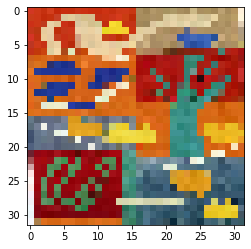

In [10]:
for image in images_dataset.take(1):
    plt.imshow(image[1])

In [11]:
def get_discriminator(new_size):
    model = Sequential()
    model.add(Input(shape=(new_size,new_size,3)))
    model.add(Conv2D(new_size,kernel_size=4,strides=2,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(new_size*2,kernel_size=4,strides=2,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(new_size*2,kernel_size=4,strides=2,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    return model
    

In [12]:
discriminator = get_discriminator(new_size)

In [13]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        1568      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32832     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          65600     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [14]:
def get_generator(z_dim,hidden_dim):
    model=Sequential()
    model.add(Input(shape=(z_dim)))
    model.add(Dense(8 * 8 * z_dim))
    model.add(Reshape((8, 8, z_dim)))
    
    model.add(Conv2DTranspose(4*hidden_dim, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    '''
    
    model.add(Conv2DTranspose(2*hidden_dim, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv2DTranspose(hidden_dim, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    '''
   
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same" , activation = 'tanh'))
    
    return model

In [15]:
generator = get_generator(z_dim,gen_hidden_dim)

In [16]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 256)       1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 3)         12291     
Total params: 1,594,627
Trainable params: 1,594,115
Non-trainable params: 512
__________________________________________

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def get_noise(num_imgs,z_dim):
    noise_vector = tf.random.normal(shape=(num_imgs, z_dim))
    return noise_vector

In [19]:
def discriminator_loss(real_img,z_dim,cross_entropy,num_imgs,discriminator,generator):
    noise_vector = get_noise(num_imgs,z_dim)
    fake_img = generator(noise_vector)
    disc_fake_pred = discriminator(fake_img,training=True)
    disc_real_pred = discriminator(real_img,training=True)
    real_loss=cross_entropy(tf.ones_like(disc_real_pred),disc_real_pred)
    fake_loss = cross_entropy(tf.zeros_like(disc_fake_pred),disc_fake_pred)
    total_loss = (real_loss + fake_loss) / 2
    return total_loss

In [20]:
def generator_loss(num_imgs,z_dim,cross_entropy,discriminator,generator):
    noise_vector = get_noise(num_imgs,z_dim)
    fake_img = generator(noise_vector,training=True)
    disc_fake_pred = discriminator(fake_img)
    loss = cross_entropy(tf.ones_like(disc_fake_pred),disc_fake_pred)
    return loss

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
checkpoint_path = "model_checkpoints/dcgan/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
#generate and save 10 images for each epoch
os.mkdir('generated_images')
def generate_and_save(epoch):
    noise_vector = get_noise(10,z_dim)
    fake_images=generator(noise_vector)
    dir_name='generated_images/epoch' + str(epoch)
    os.mkdir(dir_name)
    for index,image in enumerate(fake_images):
        #image = cv2.cvtColor(image.numpy())
        filename = 'generated_images/epoch' + str(epoch)+ '/' + str(index)+'.jpg'
        #cv2.imwrite(filename, image) 
        tf.keras.utils.save_img(filename, image)

        
    
    

In [24]:
@tf.function
def train_step(images):#,z_dim,cross_entropy,discriminator,generator,batch_size):
    num_imgs = batch_size
    real_img = images
    


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    
        disc_loss = discriminator_loss(real_img,z_dim,cross_entropy,num_imgs,discriminator,generator)
    
    
        gen_loss = generator_loss(num_imgs,z_dim,cross_entropy,discriminator,generator)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def train(images_dataset,epochs):
    for epoch in range(epochs):
        pb_i = Progbar(num_samples)
        start = time.time()
        for image_batch in images_dataset:
            
            train_step(image_batch)
            pb_i.add(batch_size)
        
        checkpoint.save(file_prefix = checkpoint_prefix) # save after every epoch
        generate_and_save(epoch) #save 10 images 
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        

In [26]:
train(images_dataset, EPOCHS)

/home/ec2-user/SageMaker/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


2816/2782 [==============================] - 90s 32ms/step
Time for epoch 1 is 89.88254284858704 sec
2816/2782 [==============================] - 26s 9ms/step
Time for epoch 2 is 26.355818033218384 sec
2816/2782 [==============================] - 126s 45ms/step
Time for epoch 3 is 125.82816076278687 sec
2816/2782 [==============================] - 136s 48ms/step
Time for epoch 4 is 135.66741394996643 sec
2816/2782 [==============================] - 25s 9ms/step
Time for epoch 5 is 24.86826777458191 sec
2816/2782 [==============================] - 81s 29ms/step
Time for epoch 6 is 81.09365510940552 sec
2816/2782 [==============================] - 131s 47ms/step
Time for epoch 7 is 131.41349291801453 sec
2816/2782 [==============================] - 76s 27ms/step
Time for epoch 8 is 75.86506247520447 sec
2816/2782 [==============================] - 42s 15ms/step
Time for epoch 9 is 42.58872842788696 sec
2816/2782 [==============================] - 138s 49ms/step
Time for epoch 10 is 138.3

In [27]:
generator.save('models/dcgan/generator')
discriminator.save('models/dcgan/discriminator')

INFO:tensorflow:Assets written to: models/dcgan/generator/assets
INFO:tensorflow:Assets written to: models/dcgan/discriminator/assets


In [28]:
#generate an image
noise_vector = get_noise(10,z_dim)
fake_image=generator(noise_vector)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


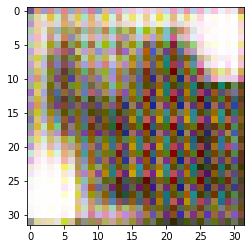

In [29]:
plt.imshow(fake_image[0])

In [ ]:
#train for longer for better results